# Import

In [82]:
# default
import numpy as np 
import pandas as pd 
import os

# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
import networkx as nx
import plotly.graph_objects as go

# read file
question = pd.read_csv('data/2019/questions_only.csv')
schema = pd.read_csv('data/2019/survey_schema.csv')
multiple_choice = pd.read_csv('data/2019/multiple_choice_responses.csv')
other_text =  pd.read_csv('data/2019/other_text_responses.csv')

In [83]:
multiple_choice.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...,Which of the following relational database pro...
1,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,83,55-59,Female,-1,Germany,Professional degree,NaN,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1


## Before we start our analysis, let's see what questions are attractive.

In [84]:
# check the question list & return the survey answers
# 'QXX' is format of `s`
from IPython.core.display import display, HTML

def q_list(s):
    lst = []
    for i in multiple_choice.columns:
        if i[:3]==s:
            lst.append(i)
    df = multiple_choice[lst]

    df_sub = df.iloc[0].apply(lambda x: ''.join(x.split('-')[2:]))
    q = ''.join([f'<li>{i}</li>' for i in df_sub.values])
    display(HTML(f'<div style="background: #f7f5f5; padding: 10px; border-radius: 10px;"> <h3 style="color:#20639B; padding:10px">{s} : {question.T[0][int(s[1:])]} </h3><ol style="color:Black;">{q}</ol> <div>'))
    return df, df_sub

In [85]:
q = ''.join([f'<li>{i}</li>' for i in question.T[0][1:]])
display(HTML(f'<div style="background: #f6f4f4; padding: 10px; border-radius: 10px;">  <h2 style="color:#20639B; padding:10px"> Question List</h2><ol style="color:Black;">{q}</ol> </div>'))

## And this is distribution of # of sub-questions.

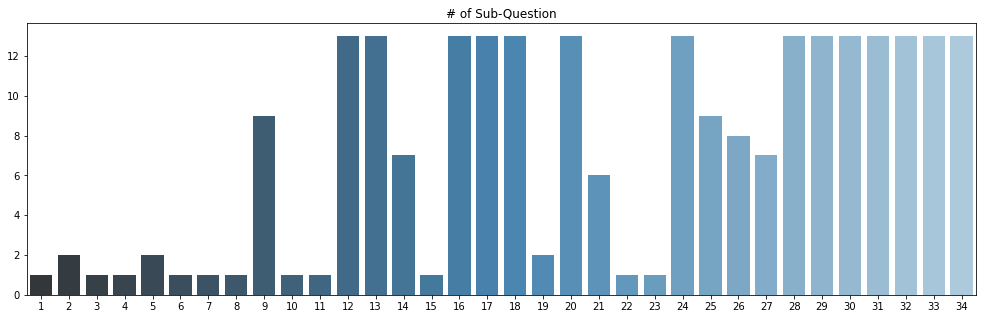

In [86]:
lst = []
for i in multiple_choice.columns[1:]:
    lst.append(i.split('_')[0])
lst = pd.Series(lst).apply(lambda x : int(x[1:]))
cnt = lst.value_counts().sort_index()

fig, ax = plt.subplots(1,1,figsize=(17,5))
sns.barplot(cnt.index, cnt, palette="Blues_d", ax=ax)
ax.set_title('# of Sub-Question')
plt.show()

## 1. Simple Distribution (Gender, Country)

In [87]:
dist = multiple_choice[['Q1', 'Q2', 'Q3']]
dist = dist.rename(columns={"Q1": "Age", "Q2": "Gender", "Q3":"Country"})
dist.drop(0, axis=0, inplace=True)

In [89]:
y = dist.Country.value_counts()

fig = go.Figure(go.Treemap(
    labels = y.index,
    parents = ['World'] * len(y),
    values = y
))

fig.update_layout(title = '# of Survey Participants')
fig.show()

## 2. Which Algorithm is most popular?

In [90]:
q24_df, q24_sub = q_list('Q24')

In [91]:
q24_df.drop(0, axis=0, inplace=True)

In [92]:
q24_convert = {b:a for a, b in zip(q24_sub.values, q24_df.columns)}
q24_df.rename(columns=q24_convert, inplace=True)

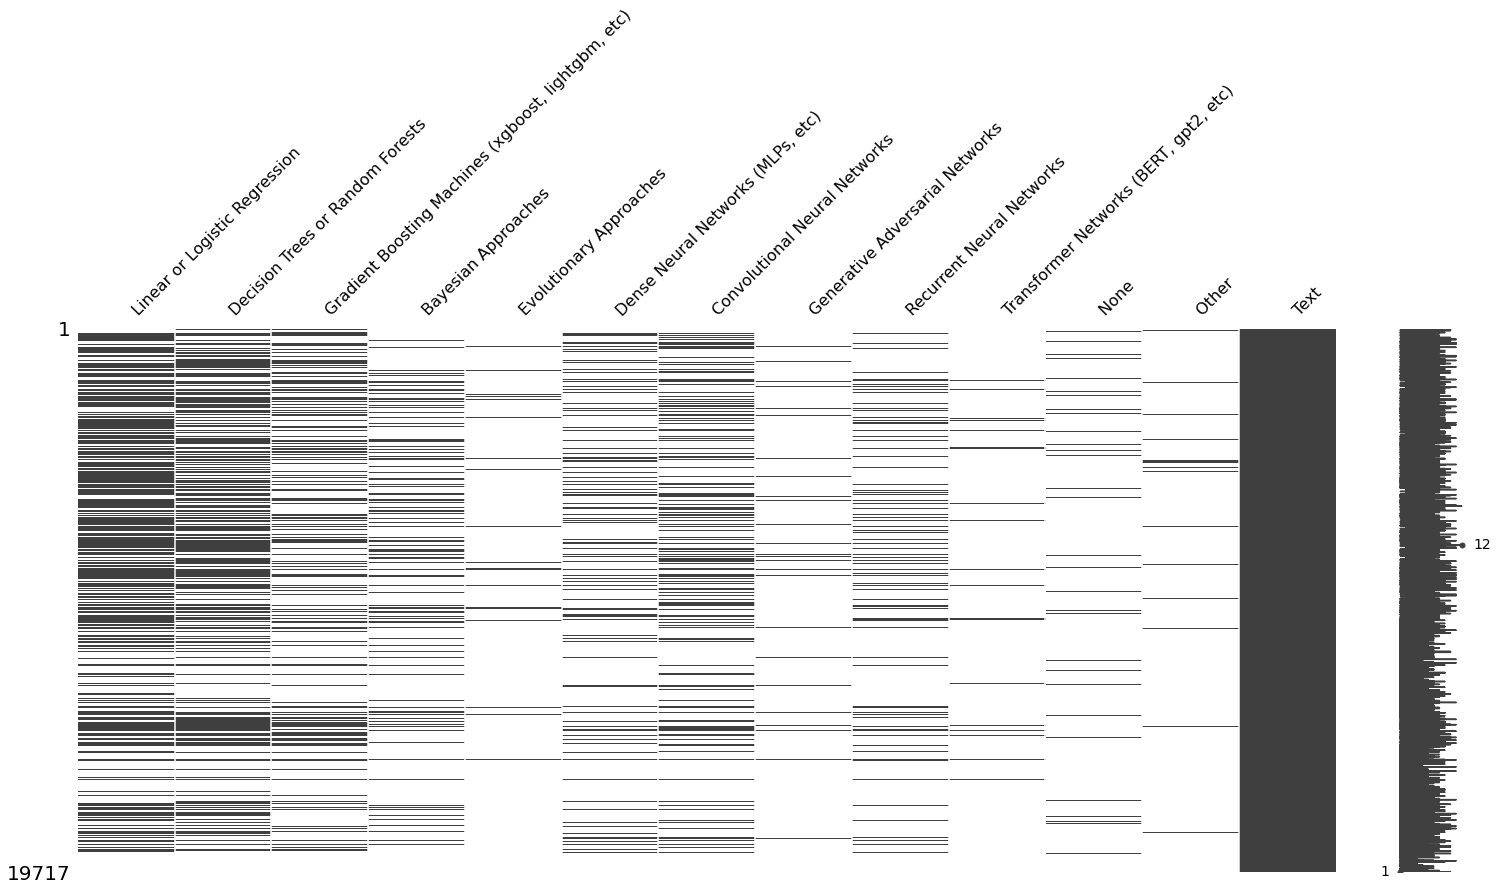

In [93]:
msno.matrix(q24_df)

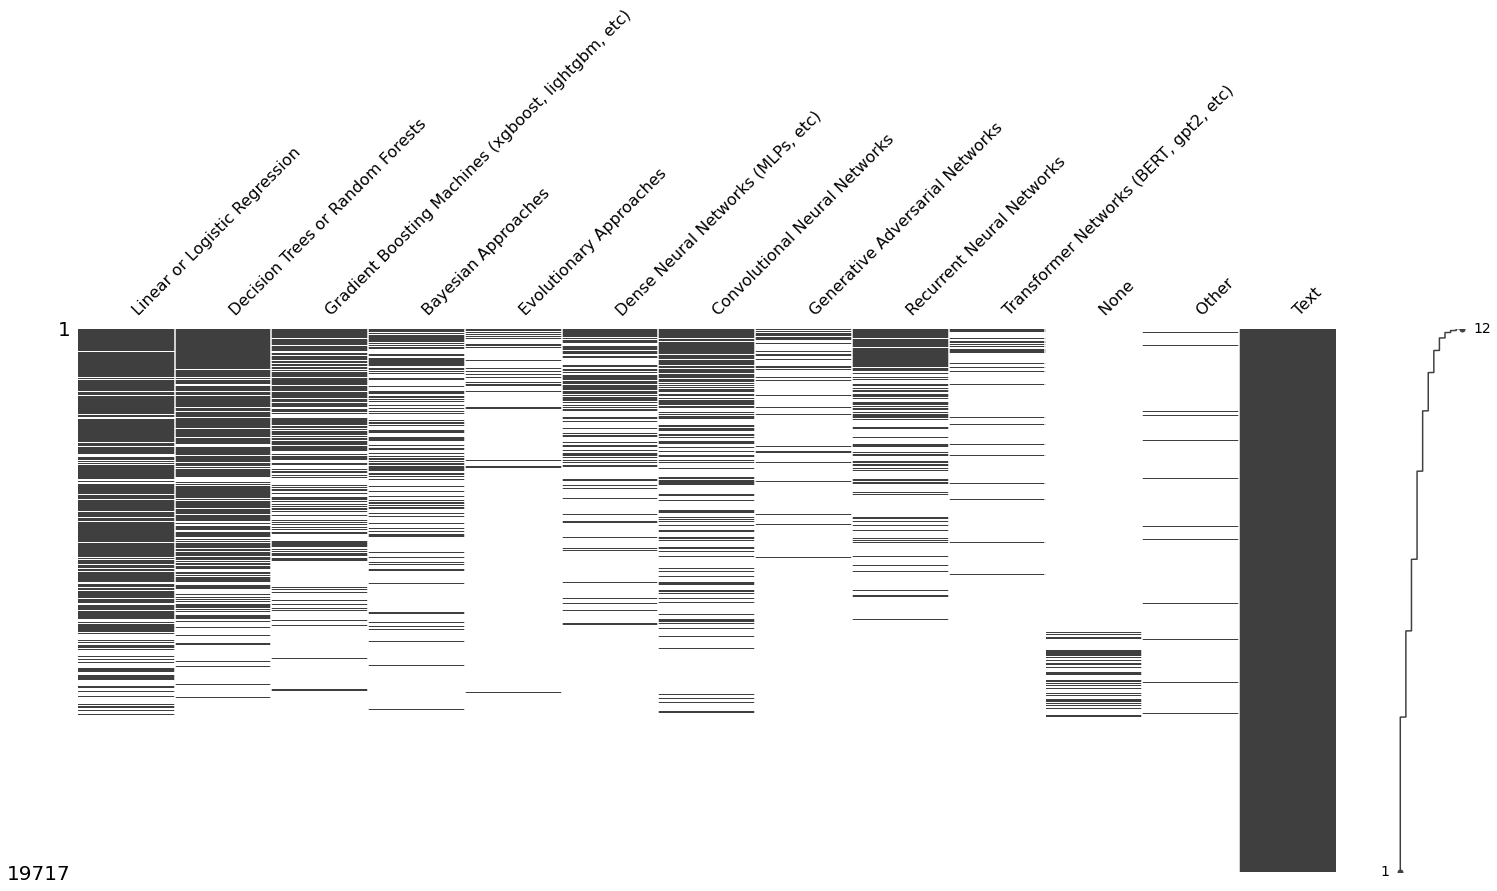

In [94]:
msno.matrix(q24_df, sort='descending')

In [95]:
# sns.heatmap(q24_df.corr())
q24_df.drop([' Text'], axis=1, inplace=True)
q24_df = q24_df.fillna(0).apply(lambda x : x!=0)

In [96]:
q24_df.drop([' None',' Other'], axis=1, inplace=True)

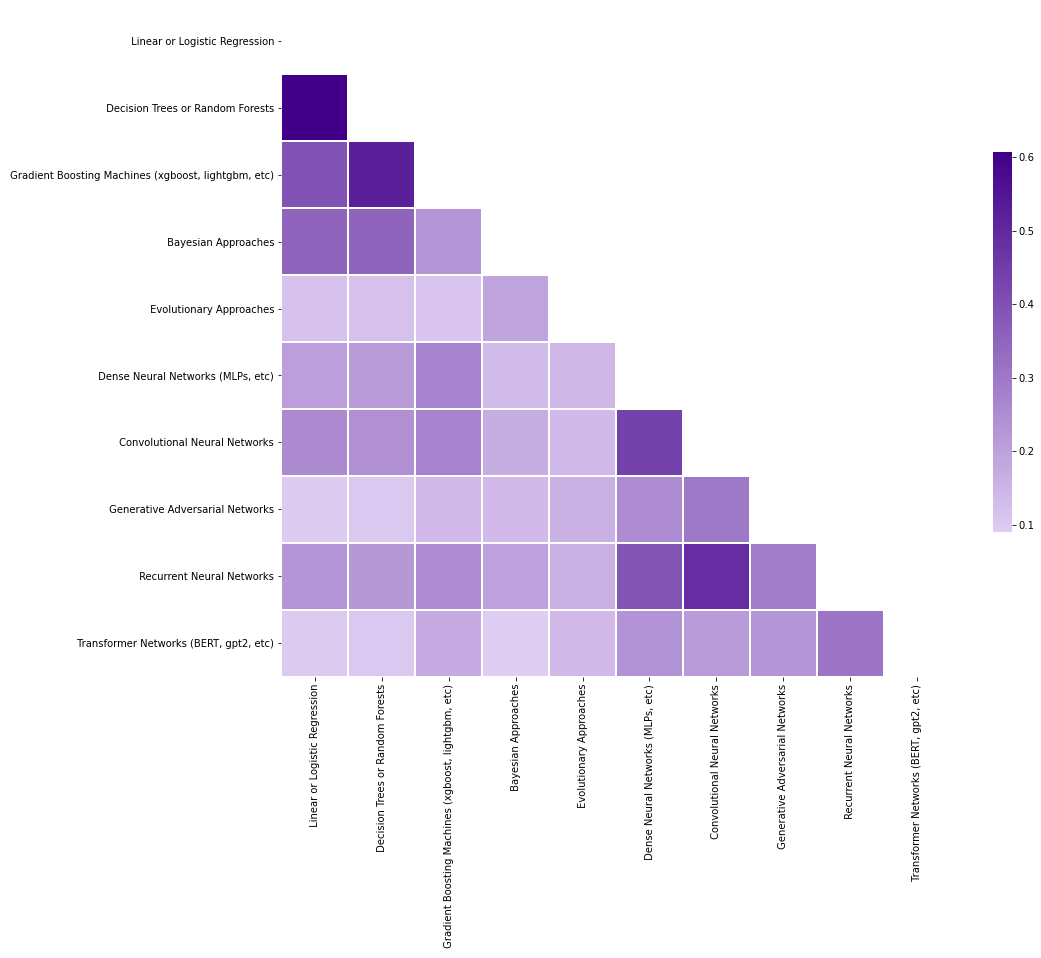

In [97]:
corr = q24_df.corr()


mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 14))
cmap = sns.diverging_palette(150, 275, s=100, l=20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 3. How about ML Frameworks & Tools?

In [98]:
q25_df, q25_sub = q_list('Q25')

In [99]:
q25_convert = {b:a for a, b in zip(q25_sub.values, q25_df.columns)}
q25_df.rename(columns=q25_convert, inplace=True)

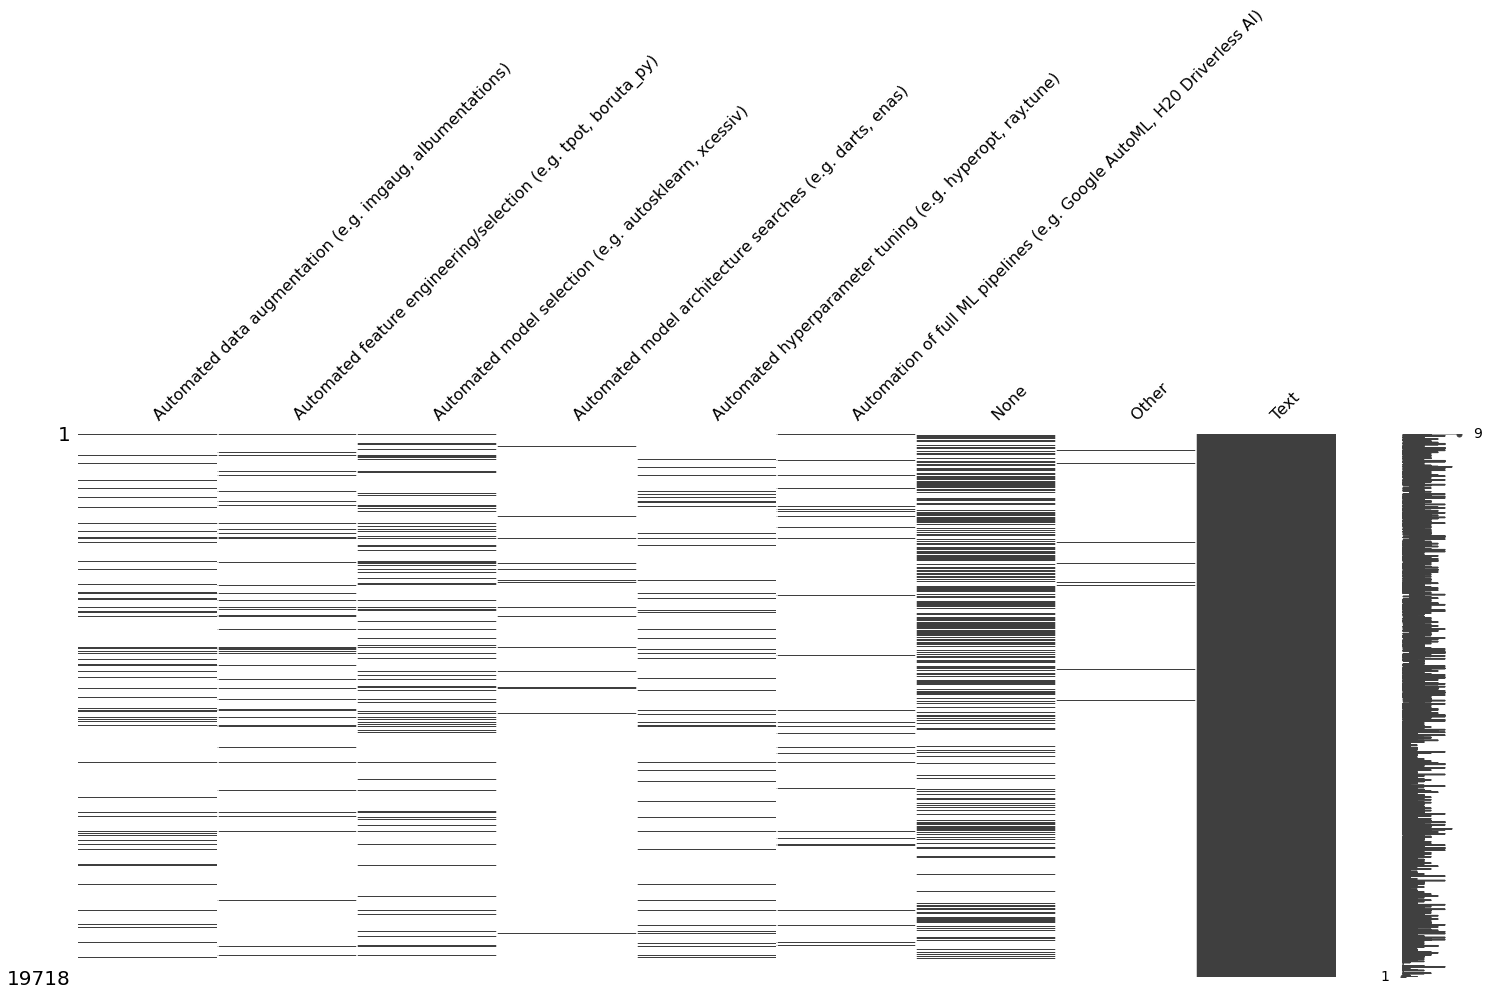

In [100]:
msno.matrix(q25_df)

In [101]:
print('There are {} other text answers'.format(len(other_text['Q25_OTHER_TEXT'].dropna())))

There are 141 other text answers


In [102]:
q28_df, q28_sub = q_list('Q28')

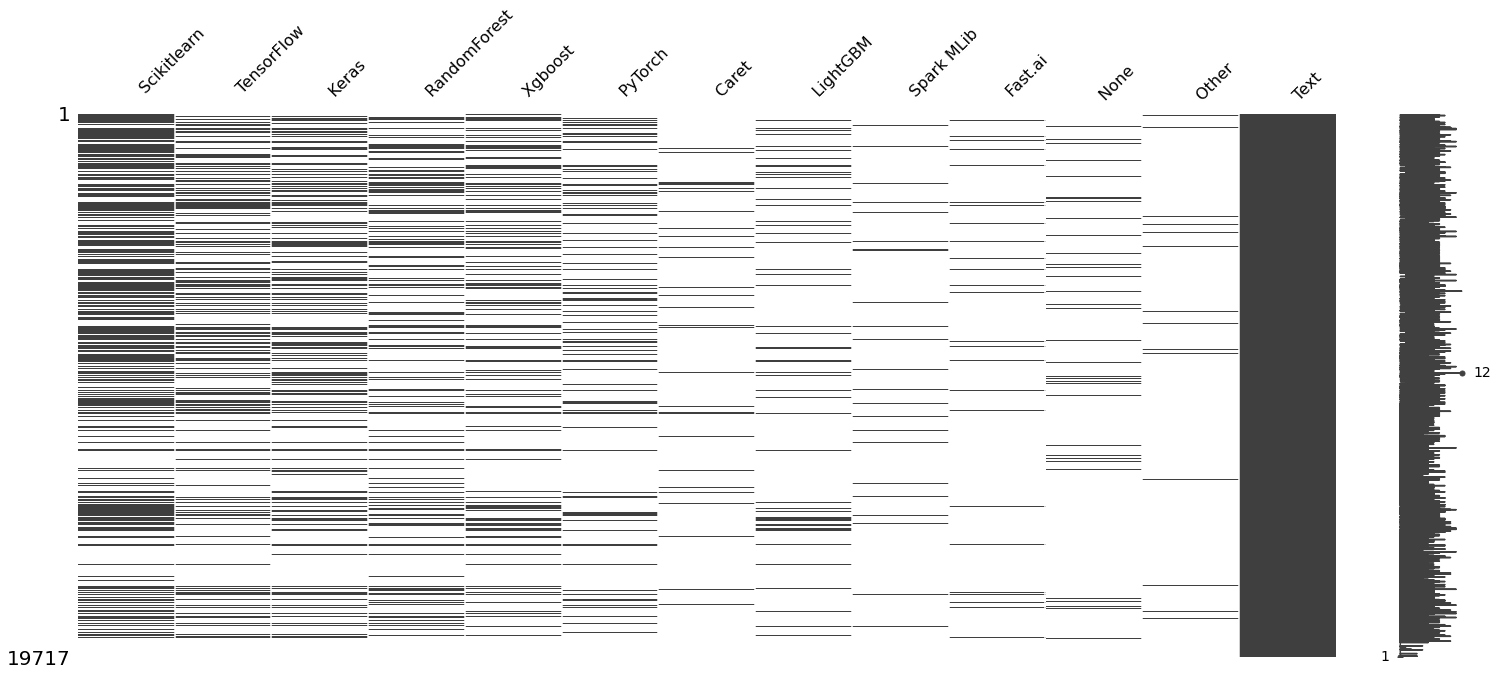

In [103]:
q28_df.drop(0, axis=0, inplace=True)
q28_convert = {b:a for a, b in zip(q28_sub.values, q28_df.columns)}
q28_df.rename(columns=q28_convert, inplace=True)
msno.matrix(q28_df)

In [104]:
q28_ans = {}
for i in q28_df.columns[:-1]:
    q28_ans.update(q28_df[i].value_counts())

q28_cnt = pd.Series(q28_ans)

print(q28_cnt)

q28_cnt.to_json("data/ML_basis_Framworks_Ranking.json", orient="split")


fig = go.Figure([go.Bar(x=q28_cnt.index, y=q28_cnt)])
fig.update_layout(title="ML basis Framworks Ranking")
fig.show()

Scikit-learn     9390
  TensorFlow       5822
 Keras             5756
 RandomForest      4524
 Xgboost           4243
 PyTorch           3412
 Caret             1139
 LightGBM          2166
 Spark MLib         910
 Fast.ai            949
None               1720
Other               342
dtype: int64


In [105]:
y = q28_cnt

fig = go.Figure(go.Treemap(
    labels = y.index,
    parents = ['Framework'] * len(y),
    values = y
))

fig.update_layout(title = 'Treemap of Hot Frameworks')
fig.show()

In [106]:
q28_df = q28_df.fillna(0).apply(lambda x : x!=0)
q28_df.drop([' None', ' Other', ' Text'], axis=1, inplace=True)

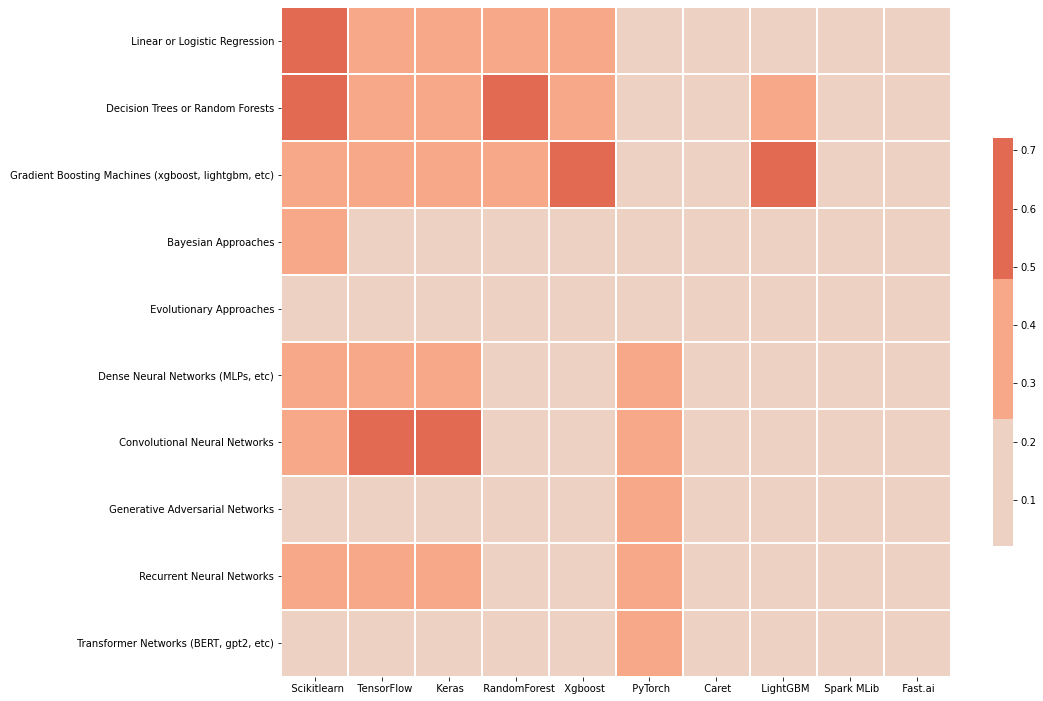

In [107]:
ML = pd.concat([q24_df, q28_df], axis=1)
fig, ax = plt.subplots(1,1, figsize=(15, 15))
sns.heatmap(ML.corr().iloc[0:10,10:], cmap=sns.color_palette("coolwarm"), center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## 4. How About Programming Language?

In [108]:
q19_cnt = multiple_choice['Q19'].value_counts()[:-1]
print(type(q19_cnt))
q19_cnt.to_json("data/Programming_Language_Ranking.json", orient="split")

fig = go.Figure([go.Bar(x=q19_cnt.index, y=q19_cnt, marker_color='crimson')])
fig.update_layout(title="Programming Language Ranking")
fig.show()

<class 'pandas.core.series.Series'>


In [109]:
q18_df, q18_sub = q_list('Q18')

## 5. What is the relationship between ML Career and Language recommendations?

In [110]:
data = multiple_choice[['Q19', 'Q23']]
data.drop(0, axis=0, inplace=True)

In [111]:
career = data['Q23'].value_counts()

fig = go.Figure([go.Bar(x=career.index, y=career, marker_color='#F6CD8B')])
fig.update_layout(title="Distribution of ML Career")
fig.show()

In [112]:
q34_df, q34_sub = q_list('Q34')
q34_df.drop(0,axis=0,inplace=True)

In [113]:
q34_ans = {}
for i in q34_df.columns[:-1]:
    q34_ans.update(q34_df[i].value_counts())

q34_cnt = pd.Series(q34_ans)

print(q34_cnt)
q34_cnt.to_json("data/database.json", orient="split")

fig = go.Figure([go.Bar(x=q34_cnt.index, y=q34_cnt, marker_color='darkseagreen')])
fig.update_layout(title="Database")
fig.show()

MySQL                              3122
PostgresSQL                        2160
SQLite                             1527
Microsoft SQL Server               1852
Oracle Database                    1192
Microsoft Access                    547
AWS Relational Database Service     588
AWS DynamoDB                        415
Azure SQL Database                  479
Google Cloud SQL                    526
None                               1245
Other                               287
dtype: int64


In [114]:
q16_df, q16_sub = q_list('Q16')
q16_df.drop(0, axis=0, inplace=True)

In [115]:
q16_ans = {}
for i in q16_df.columns[:-1]:
    q16_ans.update(q16_df[i].value_counts())

q16_cnt = pd.Series(q16_ans)

q16_cnt.to_json("data/ide.json", orient="split")

fig = go.Figure([go.Bar(x=q16_cnt.index, y=q16_cnt, marker_color='mediumturquoise')])
fig.update_layout(title="IDE")
fig.show()

In [116]:
q18_df, q18_sub = q_list('Q18')
q18_df.drop(0, axis=0, inplace=True)
q18_convert = {b:a for a, b in zip(q18_sub.values, q18_df.columns)}
q18_df.rename(columns=q18_convert, inplace=True)

In [117]:
jobs_lang = multiple_choice[['Q5']]
jobs_lang.drop(0, axis=0, inplace=True)

jobs_lang = pd.concat([jobs_lang, q18_df], axis=1).fillna('')

job_lang_table = pd.DataFrame(index = jobs_lang['Q5'].unique())

labels = list(jobs_lang['Q5'].unique())
parents = [''] * len(jobs_lang['Q5'].unique())
values = [jobs_lang['Q5'].value_counts()[i] for i in jobs_lang['Q5'].unique()]

for i in q18_sub[:-2]:
    tmp = jobs_lang.groupby('Q5')[i].value_counts()
    for val, idx in zip(tmp, tmp.index):
        if idx[0] == '' or idx[1] == '': continue 
        print(val, idx)
        labels.append(idx[1])
        parents.append(idx[0])
        values.append(val)

fig = go.Figure(go.Treemap(
    labels = labels,
    parents = parents,
    values = values,
))

fig.show()

416 ('Business Analyst', 'Python')
90 ('DBA/Database Engineer', 'Python')
982 ('Data Analyst', 'Python')
432 ('Data Engineer', 'Python')
3134 ('Data Scientist', 'Python')
660 ('Not employed', 'Python')
1003 ('Other', 'Python')
460 ('Product/Project Manager', 'Python')
985 ('Research Scientist', 'Python')
1737 ('Software Engineer', 'Python')
124 ('Statistician', 'Python')
2818 ('Student', 'Python')
192 ('Business Analyst', 'R')
42 ('DBA/Database Engineer', 'R')
553 ('Data Analyst', 'R')
126 ('Data Engineer', 'R')
1374 ('Data Scientist', 'R')
192 ('Not employed', 'R')
372 ('Other', 'R')
172 ('Product/Project Manager', 'R')
378 ('Research Scientist', 'R')
274 ('Software Engineer', 'R')
169 ('Statistician', 'R')
744 ('Student', 'R')
288 ('Business Analyst', 'SQL')
100 ('DBA/Database Engineer', 'SQL')
796 ('Data Analyst', 'SQL')
311 ('Data Engineer', 'SQL')
1926 ('Data Scientist', 'SQL')
266 ('Not employed', 'SQL')
442 ('Other', 'SQL')
280 ('Product/Project Manager', 'SQL')
265 ('Research S

In [119]:
q13_df, q13_sub = q_list('Q13')
q13_df.drop(0, axis=0, inplace=True)

In [120]:
q13_ans = {}
for i in q13_df.columns[:-1]:
    q13_ans.update(q13_df[i].value_counts())

q13_cnt = pd.Series(q13_ans)
q13_cnt.to_json("data/study_ml.json", orient="split")

fig = go.Figure([go.Bar(x=q13_cnt.index, y=q13_cnt, marker_color='salmon')])
fig.update_layout(title="Best Place to Study ML")
fig.show()